# Import the modules

In [23]:
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pickle
#from wordcloud import WordCloud
%matplotlib inline

# Import the data

In [24]:
# File and folder names
DATA_FOLDER = 'Data/'
CHARACTER_DATASET = DATA_FOLDER + 'characters.pkl'
MOVIE_DATASET = DATA_FOLDER + 'movies.pkl'

SUMMARIES_DATASET = DATA_FOLDER + 'plot_summaries.txt'
NLP_DATASET = DATA_FOLDER + 'corenlp_plot_summaries.tar'

MALE_SENTENCES = DATA_FOLDER + "male_sentences.pkl"
FEMALE_SENTENCES = DATA_FOLDER + "female_sentences.pkl"

MALE_SENTIMENTS = DATA_FOLDER + "male_sentiments.pkl"
FEMALE_SENTIMENTS = DATA_FOLDER + "female_sentiments.pkl"

In [25]:
# Function to load data
def load_metadata(path, column_names, header=None, low_memory=False):
    return pd.read_table(path, header=header, names=column_names)

In [26]:
# Load data
characters = pd.read_pickle(CHARACTER_DATASET)
movies = pd.read_pickle(MOVIE_DATASET)

# Little cleaning

As we pickled our data, we just have to turn the dates back to the pandas datetime format.

We also keep a version of our datasets without dropping the NaN (which are quite numerous, see below).

## Dates as datetime

Change the format of dates

In [27]:
movies.Movie_release_date = pd.to_datetime(movies.Movie_release_date,format='%Y').dt.year
characters.Movie_release_date = pd.to_datetime(characters.Movie_release_date,format='%Y').dt.year
characters.Actor_date_of_birth = pd.to_datetime(characters.Actor_date_of_birth,format='%Y',utc=True,errors='coerce').dt.year

## Rows with NaN

We detect the number of rows with NaN values for movies and characters datasets

In [28]:
print('Number of NaN in the movies dataset:\n',movies.isnull().sum())
print('>>> {perc:.2f}% of the rows with at least one NanN'.format(perc=movies.isnull().sum().max()/len(movies)*100))
print('\nNumber of NaN in the characters dataset:\n',characters.isnull().sum())
print('>>> {perc:.2f}% of the rows with at least one NanN'.format(perc=characters.isnull().sum().max()/len(characters)*100))

Number of NaN in the movies dataset:
 Wikipedia_movie_ID              0
Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64
>>> 89.72% of the rows with at least one NanN

Number of NaN in the characters dataset:
 Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_release_date                   9994
Character_name                     257856
Actor_date_of_birth                106145
Actor_gender                        45603
Actor_height_meters                295825
Actor_ethnicity_Freebase_ID        344589
Actor_name                           1228
Actor_age_at_movie_release         158102
Freebase_character_actor_map_ID         0
Freebase_character_ID              257846
Freebase_actor_ID                     815
dtype: i

In [29]:
# We separate the datasets in two parts: one with droped rows with NaN and one that we do not touch
characters_nodrop = characters.copy()
movies_nodrop = movies.copy()

characters = characters.dropna()
movies = movies.dropna()

# Visualisations

## Movies

### General statistics

In [8]:
movies_nodrop.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,74839.000000,8.401000e+03,6.129100e+04
mean,1.740784e+07,1977.489892,4.799363e+07,1.118192e+02
std,1.098791e+07,28.886090,1.121753e+08,4.360070e+03
min,3.300000e+02,1888.000000,1.000000e+04,0.000000e+00
25%,7.323695e+06,1956.000000,2.083193e+06,8.100000e+01
50%,1.777899e+07,1985.000000,1.063969e+07,9.300000e+01
75%,2.715573e+07,2004.000000,4.071696e+07,1.060000e+02
max,3.750192e+07,2016.000000,2.782275e+09,1.079281e+06


As expected, the standard variation for the box office revenue is very high. We therefore decide to use the median revenue instead of mean revenue, and plot in y log-scale.

### Some evolutions

#### About the revenue

In [9]:
# General parameters for the plots

step = 3 # step for the dates in the x-axis ticks
xmin = int(min(movies.Movie_release_date))
xmax = int(max(movies.Movie_release_date))

Evolution of box office revenue

Text(0.5, 1.0, 'Evolution of median box office revenue per year (log-linear)')

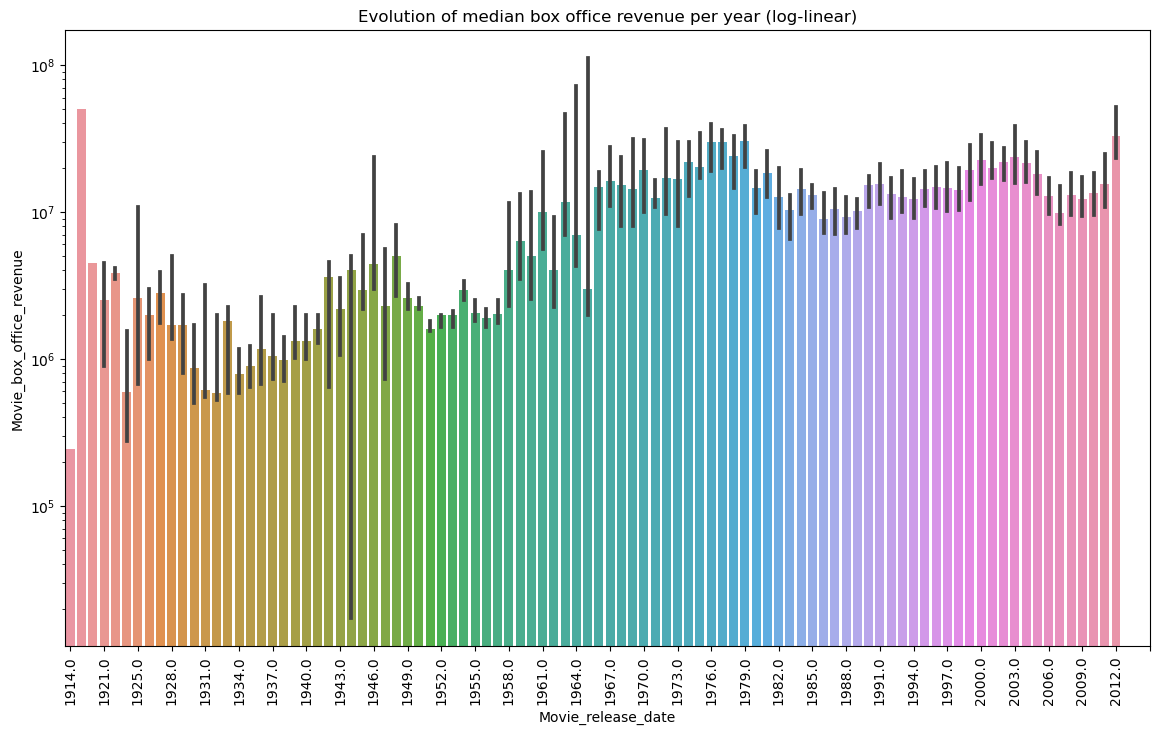

In [10]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = movies, x='Movie_release_date', y='Movie_box_office_revenue',estimator='median', ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
plt.yscale('log')
plt.title('Evolution of median box office revenue per year (log-linear)')

The high peaks in 1915 seem strange, as for the relative high revenue around 1921. Let us plot the evolution of the number of films per year (only those with a valid revenue i.e non-NaN).

Text(0.5, 1.0, 'Evolution of number of films per year (log-linear)')

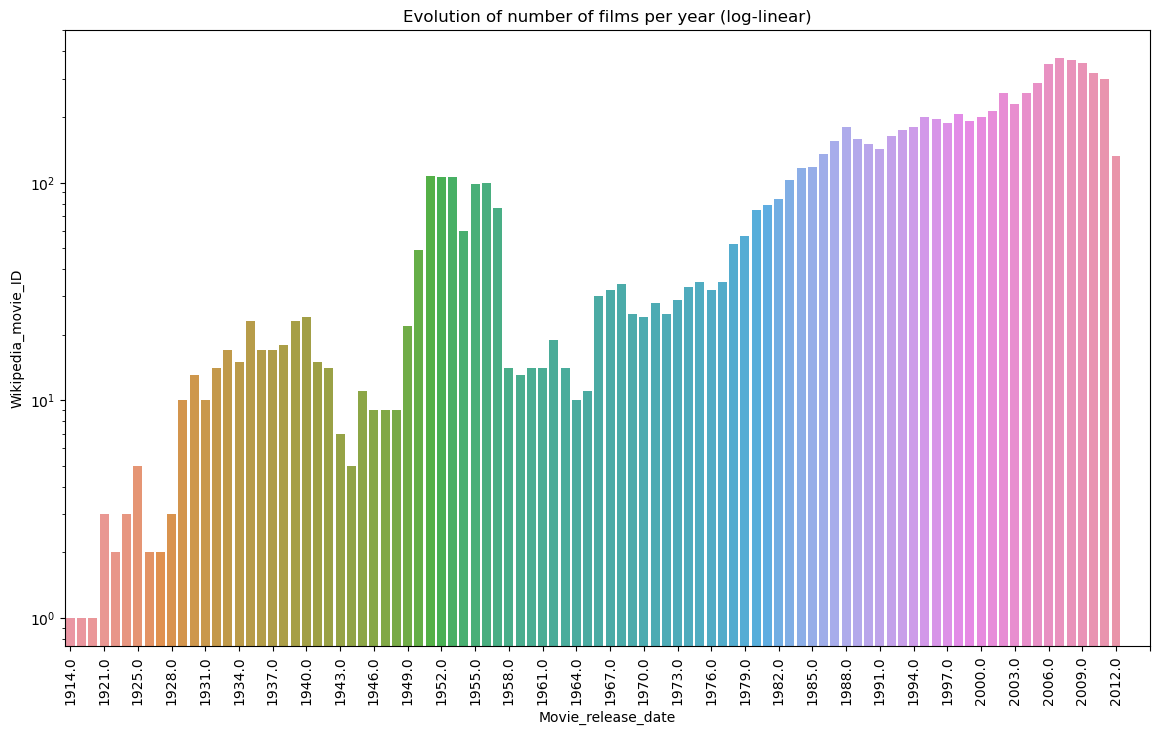

In [11]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = movies, x='Movie_release_date', y='Wikipedia_movie_ID',estimator=len, ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
#plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of number of films per year (log-linear)')

Indeed, there was only one film in 1915, and not a lot around 1921. Only the "best films" of the epoch must have been registered in the dataset.

Now let us see the evolution of the median revenue per film.

Text(0.5, 1.0, 'Evolution of median revenue per film (log-linear)')

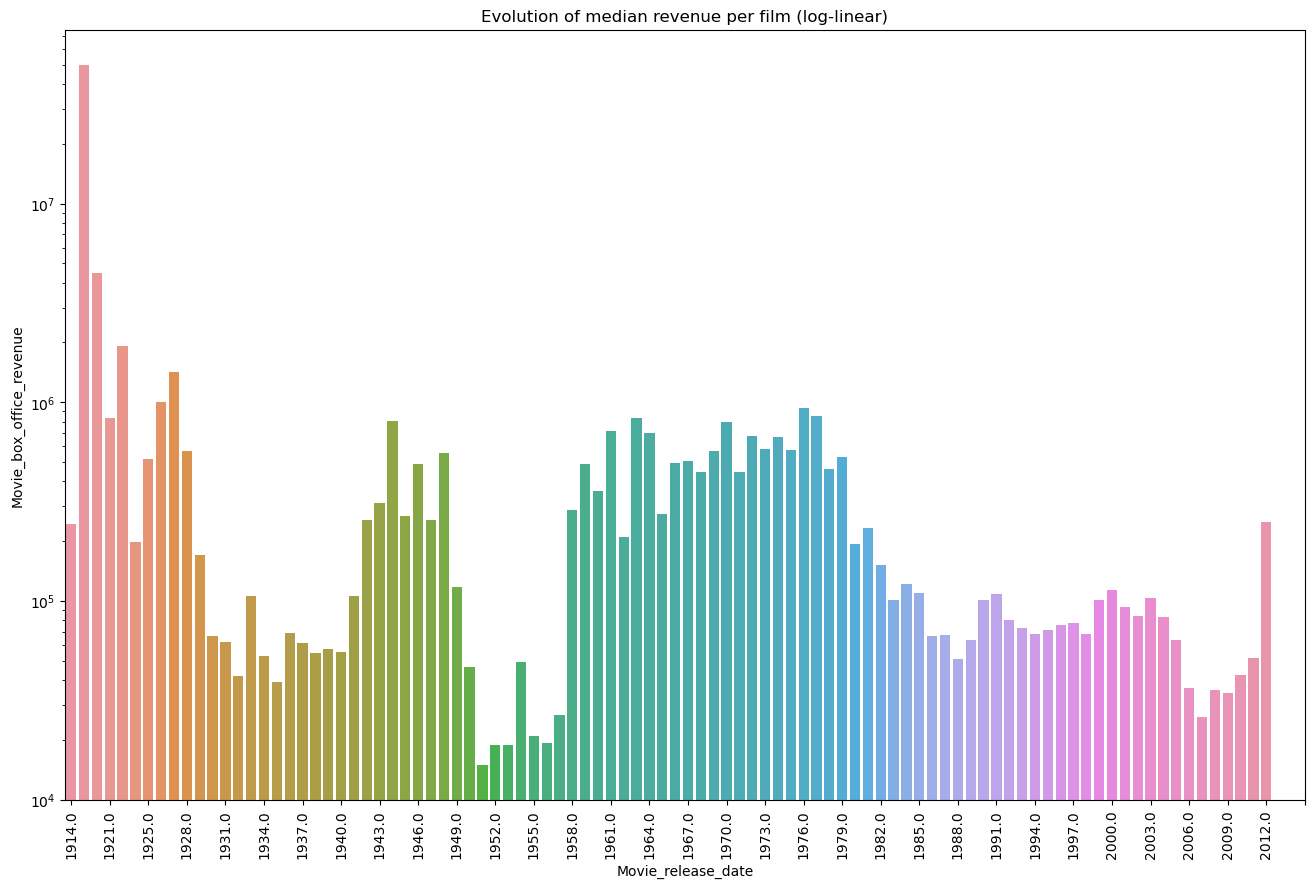

In [12]:
movies_by_year = movies.groupby('Movie_release_date')
movies_by_year_count = movies_by_year.agg('count')
movies_by_year_median = movies_by_year.agg('median',numeric_only=True)
fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(x=movies_by_year_median.index, y=movies_by_year_median.Movie_box_office_revenue/movies_by_year_count.Movie_box_office_revenue, ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
plt.yscale('log')
plt.title('Evolution of median revenue per film (log-linear)')

If we do not take in to account the first few years with very little number of films, iIt appears (not conclusive yet, but just an intuition with the plot) that the median revenue per film is "relatively constant" compared to the median revenue. There was a drop around the 50's (missing data or real effect ?), and a little decrease since 1980.

### What about the genres ?

How many movies do we have per genre ?

In [30]:
genres ={}
for i in movies_nodrop.Movie_genres:
    for j in i:
        if j not in genres:
            genres[j] = 1
        else:
            genres[j]+=1
sorted_genres = sorted(genres.items(), key=lambda x:x[1],reverse=True)
sorted_genres

[('Drama', 34007),
 ('Comedy', 16349),
 ('Romance Film', 10234),
 ('Black-and-white', 9094),
 ('Action', 8798),
 ('Thriller', 8744),
 ('Short Film', 8141),
 ('World cinema', 7155),
 ('Crime Fiction', 6948),
 ('Indie', 6897),
 ('Documentary', 5630),
 ('Horror', 5280),
 ('Silent film', 5250),
 ('Adventure', 4963),
 ('Family Film', 4598),
 ('Action/Adventure', 4561),
 ('Comedy film', 4362),
 ('Musical', 4160),
 ('Animation', 3534),
 ('Romantic drama', 3372),
 ('Mystery', 3195),
 ('Science Fiction', 3052),
 ('Fantasy', 2820),
 ('Romantic comedy', 2680),
 ('War film', 2652),
 ('Japanese Movies', 2322),
 ('Western', 2226),
 ('Crime Thriller', 2122),
 ('Period piece', 1758),
 ('Comedy-drama', 1720),
 ('Film adaptation', 1531),
 ('Chinese Movies', 1525),
 ('Biography', 1392),
 ('Psychological thriller', 1331),
 ('Bollywood', 1321),
 ('Sports', 1206),
 ('Biographical film', 1198),
 ('LGBT', 1163),
 ('Music', 1088),
 ('Family Drama', 1043),
 ('Black comedy', 1025),
 ('Parody', 999),
 ('Televisio

In [31]:
main_genres = [elt[0] for elt in sorted_genres[:25]] # Completely arbitrary choice of the number of genres to keep
revenue_per_genre = {}
for genre in main_genres:
    count = 0
    revenues = []
    for index,row in movies.iterrows():
        if genre in row.Movie_genres:
            revenues.append(row.Movie_box_office_revenue)
    revenue_per_genre[genre] = sorted(revenues)[int(len(revenues)/2)]

In [32]:
df_revenue_per_genre = pd.DataFrame.from_dict(revenue_per_genre, orient ='index')
df_revenue_per_genre.rename(columns={0:'Revenue'},inplace=True)
#df_revenue_per_genre.sort_values(by='Revenue',inplace=True,ascending=False)

Text(0.5, 1.0, 'Median revenue per genre (log scale)')

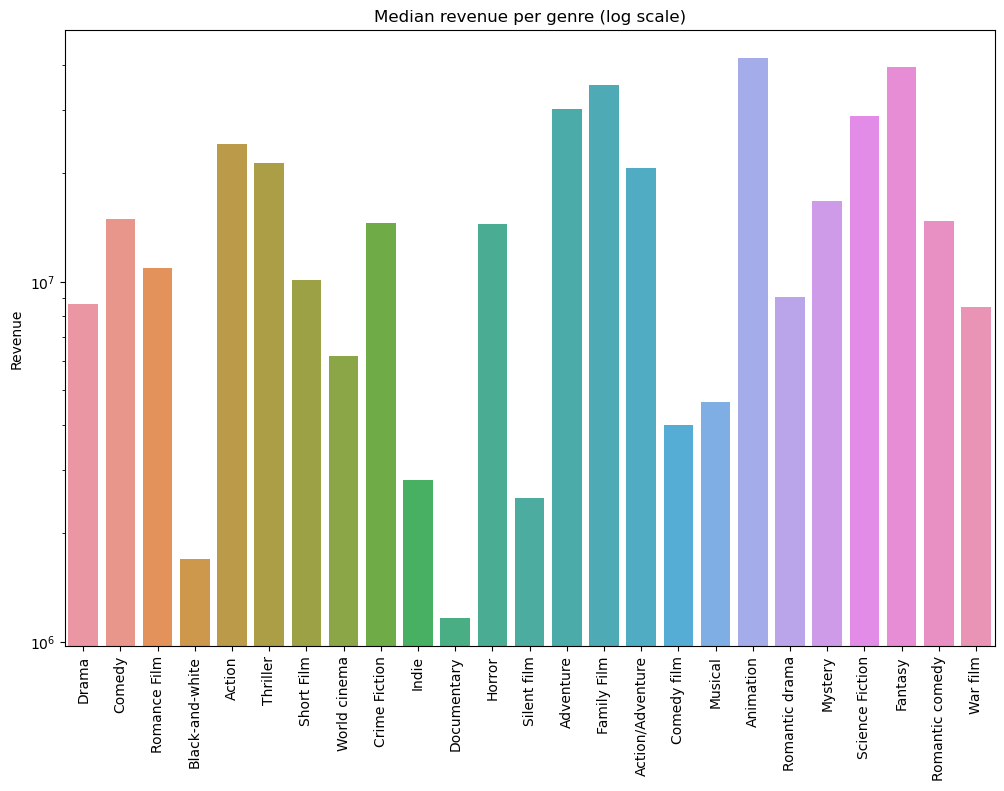

In [33]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(df_revenue_per_genre,x=df_revenue_per_genre.index,y='Revenue')
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Median revenue per genre (log scale)')

We can see that the number of films per genre do not seem to be correlated with the revenue of the film. But to be conclusive we will have to be careful about the number of genres per film (e.g if 'Drama' is always cited as a genre with 4 other genres, then the film might not be a pure Drama), and other counfounders.

Now let us have a look at the characters dataset.

## Characters

In [34]:
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006.0,Taper Guy,1971.0,M,1.87,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999.0,Sandii,1975.0,F,1.68,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


### About the numbers

How many films per actor...

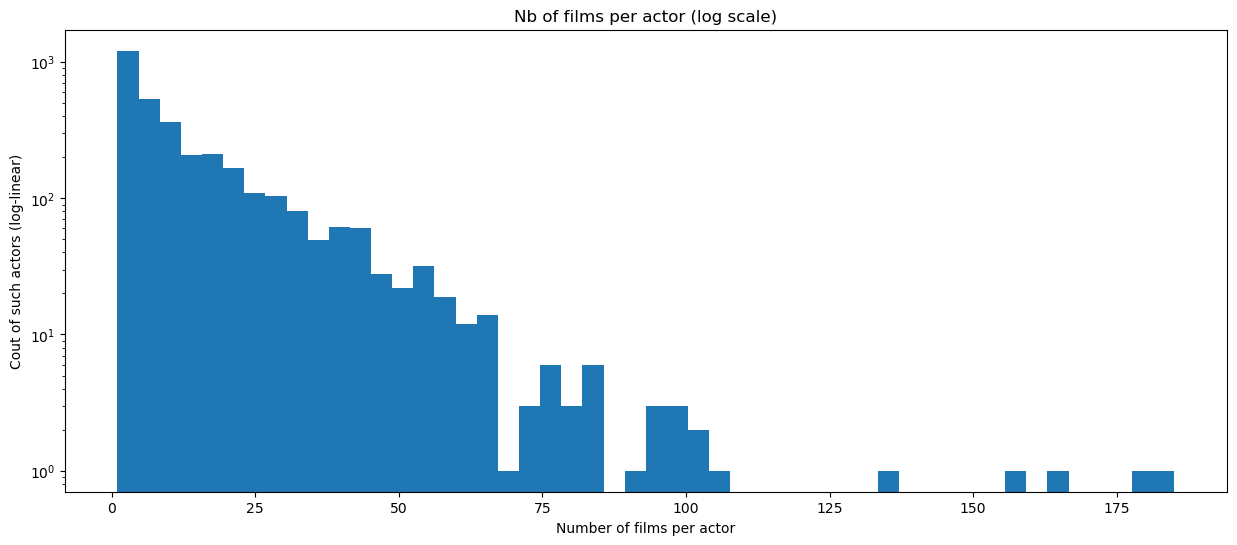

In [35]:
characters_per_actor = characters.groupby('Actor_name')
fig,ax = plt.subplots(figsize=(15,6))
plt.hist(characters_per_actor.agg('count').Wikipedia_movie_ID,bins=50)
ax.set(yscale='log')
plt.title('Nb of films per actor (log scale)')
plt.xlabel('Number of films per actor')
plt.ylabel('Cout of such actors (log-linear)')
None

... and how many characters per film (which can reasonably be assumed equal to the number of actors)

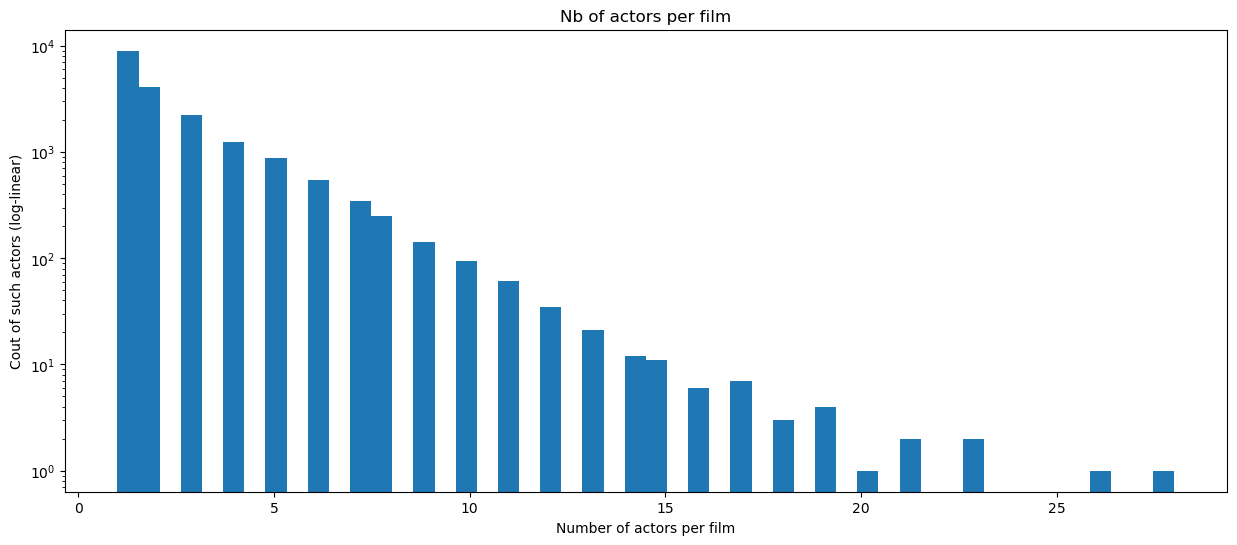

In [36]:
characters_per_film = characters.groupby('Wikipedia_movie_ID')
fig,ax = plt.subplots(figsize=(15,6))
plt.hist(characters_per_film.agg('count').Freebase_actor_ID,bins=50)
ax.set(yscale='log')
plt.title('Nb of actors per film')
plt.xlabel('Number of actors per film')
plt.ylabel('Cout of such actors (log-linear)')
None

A beautiful power-law, which tells us that only the major characters are registered in the database for the majority of films.

### Some evolutions

Conversion of gender to {0,1} (0 for male, 1 for female).

In [37]:
characters.Actor_gender = (characters.Actor_gender=='F').apply(int)
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,1,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,0,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,1,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006.0,Taper Guy,1971.0,0,1.87,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999.0,Sandii,1975.0,1,1.68,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


Text(0.5, 1.0, 'Evolution of the fraction of women in the film (1=female)')

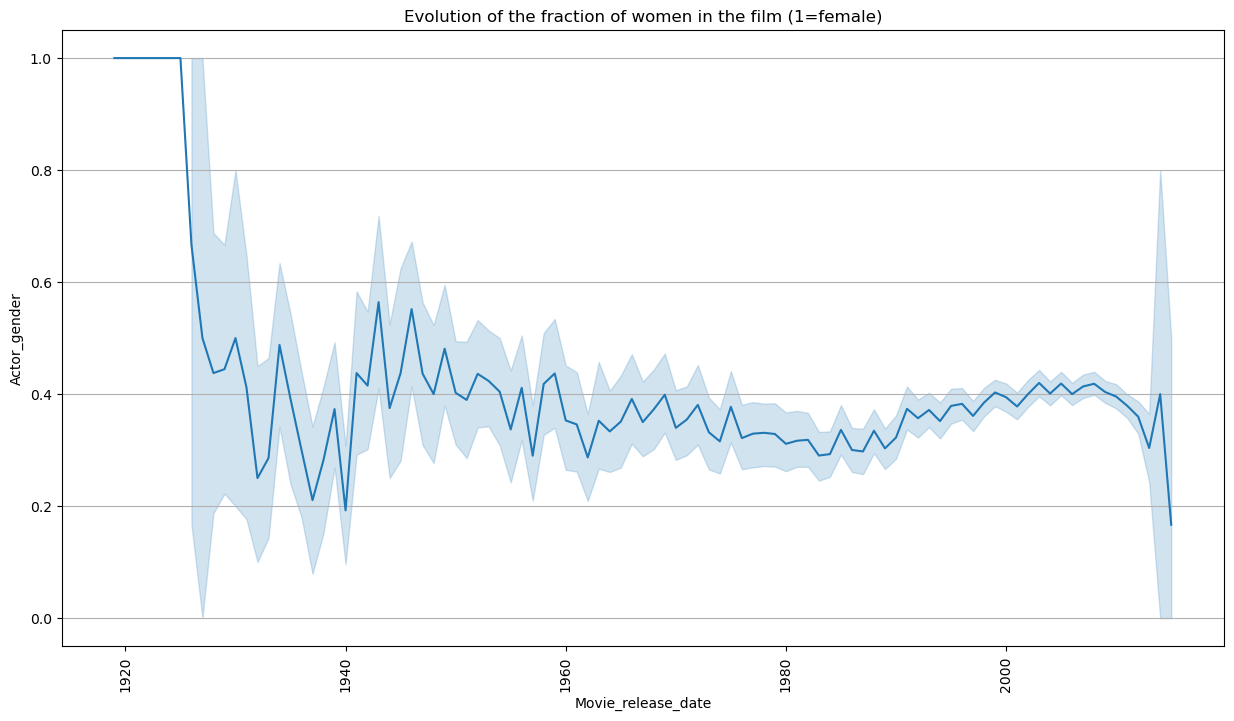

In [38]:
fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_gender', ax=ax)
plt.grid(visible=True, axis='y')
plt.xticks(rotation=90)
plt.title('Evolution of the fraction of women in the film (1=female)')

About the age of actors

Text(0.5, 1.0, 'Evolution of median age of the actor (1=female)')

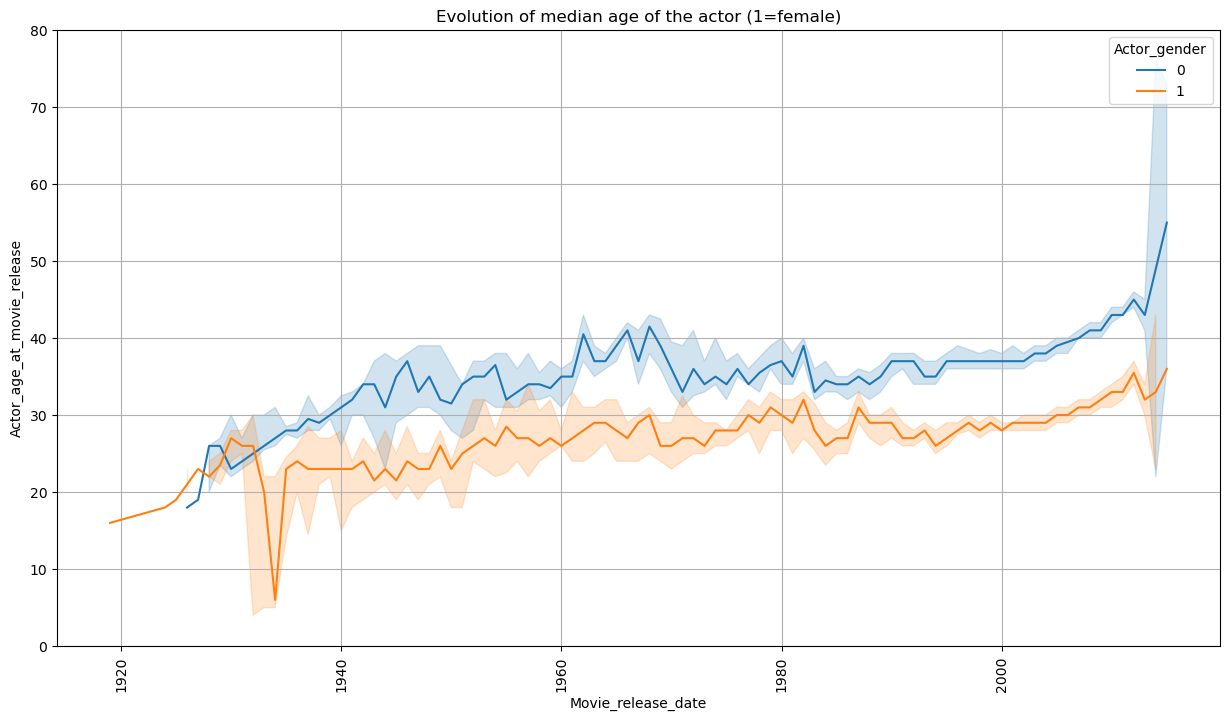

In [39]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_age_at_movie_release',hue='Actor_gender',estimator='median', ax=ax)
plt.grid(visible=True)
plt.xticks(rotation=90)
plt.ylim(0,80)
plt.title('Evolution of median age of the actor (1=female)')

# Question 1
How diverse are the actors genders in movies? How has this evolved over time? Does it change depending on genre? Movie language/place?

## New dataframe

To answer all these questions, we count the number of female/male per film

In [70]:
grouped = characters[['Wikipedia_movie_ID','Actor_gender']].groupby(characters.Wikipedia_movie_ID)
df_gender = grouped.agg('sum')
df_gender['nb_m'] = grouped['Actor_gender'].agg('count').values - grouped['Actor_gender'].agg('sum').values
df_gender.rename(columns = {'Actor_gender':'nb_f'}, inplace = True)
df_gender.head()

,nb_f,nb_m
Wikipedia_movie_ID,,
3217,2,0
3746,0,3
3837,1,5
4227,0,1
4231,3,5


In [123]:
global_mean = (df_gender.nb_f/(df_gender.nb_f+df_gender.nb_m)).mean()
global_mean

0.39330736025556756

## Part of women in films over time

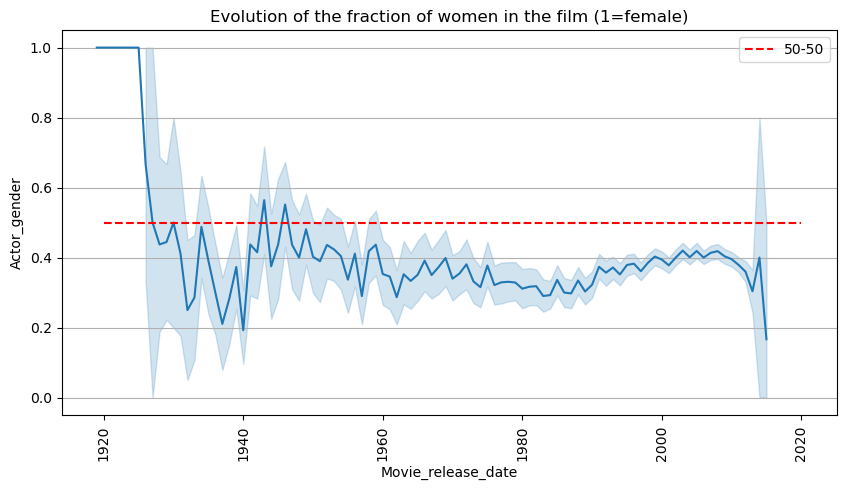

In [122]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_gender', ax=ax)
plt.hlines(0.5,1920,2020,color='r',linestyle='--',label='50-50')
plt.grid(visible=True, axis='y')
plt.xticks(rotation=90)
plt.title('Evolution of the fraction of women in the film (1=female)')
plt.legend()

## Women in films per genre

In [129]:
gender_per_genre ={}
for idx,row in movies.iterrows():
    genre_list = row.Movie_genres
    try:
        nb_f,nb_m = df_gender.loc[row.Wikipedia_movie_ID,'nb_f'],df_gender.loc[row.Wikipedia_movie_ID,'nb_m']
    except KeyError:
        continue
    for g in genre_list:
        if g not in gender_per_genre:
            gender_per_genre[g] = [nb_m,nb_f]
        else:
            gender_per_genre[g][0] += nb_m
            gender_per_genre[g][1] += nb_f
df_gender_per_genre = pd.DataFrame.from_dict(gender_per_genre,orient='index')
df_gender_per_genre['ratio'] = df_gender_per_genre[1]/(df_gender_per_genre[0]+df_gender_per_genre[1])*100
df_gender_per_genre.sort_values(by='ratio',inplace=True,ascending=False)
df_gender_per_genre_lim = df_gender_per_genre[df_gender_per_genre[0]+df_gender_per_genre[1] >= 800]
df_gender_per_genre.head(4)

,0,1,ratio
Hardcore pornography,0,1,100.0
Breakdance,0,1,100.0
Filipino Movies,0,1,100.0
Women in prison films,0,2,100.0


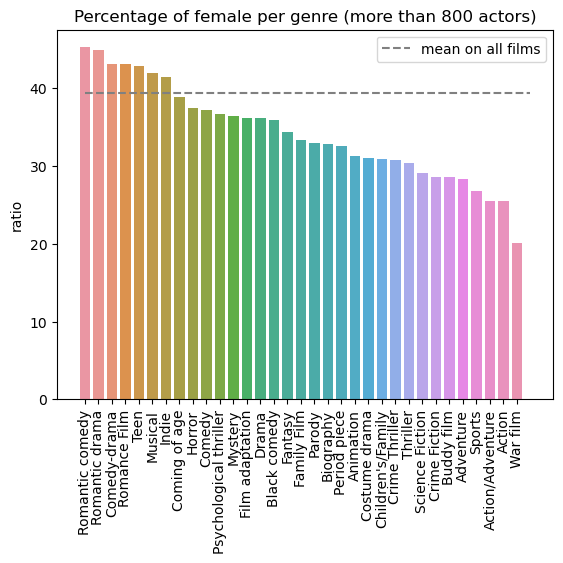

In [130]:
sns.barplot(data=df_gender_per_genre_lim, x=df_gender_per_genre_lim.index, y='ratio')
plt.hlines(global_mean*100,0,len(df_gender_per_genre_lim.index),linestyle='--',color='grey',label='mean on all films')
plt.xticks(rotation=90)
plt.title('Percentage of female per genre (more than 800 actors)')
plt.legend()

And for the 5 main genres:

In [132]:
N = 5
for elt in sorted_genres[:N]:
    print('{genre}: {ratio:.1f}\% of females'.format(genre=elt[0],ratio = df_gender_per_genre.loc[elt[0],'ratio']))

Drama: 36.1\% of females
Comedy: 37.2\% of females
Romance Film: 43.1\% of females
Black-and-white: 40.0\% of females
Action: 25.5\% of females
